# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.425914,True,10.401466
1,0.055485,False,-0.608075
2,-0.108928,True,3.233670
3,1.359787,True,8.879705
4,1.170015,True,8.832066
...,...,...,...
995,0.076541,True,4.946259
996,0.750941,True,8.754033
997,1.823980,True,12.314863
998,1.491028,True,9.198882


<AxesSubplot:xlabel='v0'>

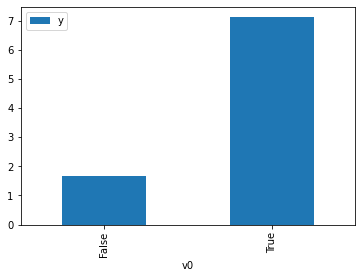

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

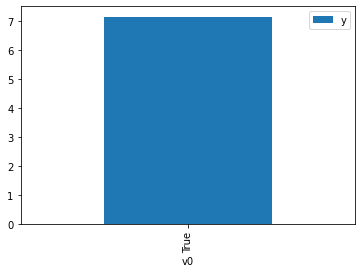

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.344008,False,3.943839,0.138950,7.196827
1,-0.868102,False,-2.161497,0.718258,1.392258
2,1.206662,False,4.611390,0.160747,6.220966
3,0.464911,False,2.319090,0.325797,3.069401
4,0.624548,False,2.597544,0.283651,3.525465
...,...,...,...,...,...
995,0.726944,False,1.333480,0.258424,3.869610
996,0.716708,False,2.566960,0.260879,3.833195
997,1.054706,False,3.353966,0.187994,5.319322
998,0.910364,False,2.855147,0.217038,4.607497


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.034091,True,5.432921,0.547298,1.827159
1,0.482306,True,5.924023,0.678952,1.472858
2,-0.064927,True,4.262485,0.516550,1.935923
3,0.303600,True,7.542944,0.628551,1.590962
4,0.214954,True,6.942535,0.602384,1.660072
...,...,...,...,...,...
995,-0.824703,True,3.579179,0.292828,3.414977
996,0.096172,True,6.299307,0.566408,1.765511
997,2.521715,True,11.809094,0.964201,1.037129
998,0.240409,True,6.382080,0.609965,1.639438


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                          2.394e+04
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        05:06:32   Log-Likelihood:                         -1427.8
No. Observations:                1000   AIC:                                      2860.
Df Residuals:                     998   BIC:                                      2869.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5737      0.035     72.720      0.000       2.504       2.643
x2             5.0266      0.054     92.865      0.000       4.920       5.133
==============================================================================
Omnibus:                        0.434   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.361
Skew:                           0.042   Prob(JB):                        0.835
Kurtosis:                       3.039   Cond. No.                         2.75
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""